# Implementación del algoritmo K-means++ con cálculo del número de clústeres relativamente oṕtimo para puntos con movimiento aleatorio y predicción de cambio en el tiempo.

A diferencia con los otros notebooks, este se va a utlizar para mostrar el algoritmo completo, como si de un único archivo se tratase. Con ello podemos controlar mejor la ejecución del algoritmo.

Importamos las librerías que vamos a emplear, cargamos y representamos los puntos:

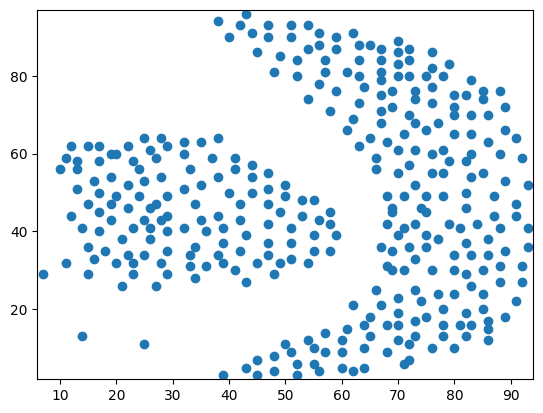

In [1]:
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics

with open("Datasets/a.csv") as input_file:
    input_values = input_file.read()

x = [] # Lista de valores x
y = [] # Lista de valores y
point_class = [] # Lista de valores de los puntos
input_offset = 3
input_values = input_values.splitlines()[1 :: ]
for point in input_values:
    splitted_point = point.split(",")
    x.append(float(splitted_point[0]))
    y.append(float(splitted_point[1]))
    point_class.append(float(splitted_point[2]))

plt.ylim(min(y) - 1, max(y) + 1)
plt.xlim(min(x) - 1, max(x) + 1)
plt.scatter(x, y)
plt.show()


Implementamos el algoritmo:

In [2]:
def mean(list): # Función que calcula la media de una lista
    acc = 0
    for i in list:
        acc = acc + i
    return acc/len(list)

def initialize(k="Number of centroids", d="Data points"):
    centroids = []
    point_distance_to_centroids = [[]] # Guarda la distancia de cada punto a cada centroide
    distance_to_first_centroid = []
    # Escojo como primer centroide el valor más cercano a la media
    mean_x_coord = mean(d[0])
    mean_y_coord = mean(d[1])
    
    for point_index in range(len(d[0])): # Calculo la distancia 
        distance_to_first_centroid.append(abs(math.sqrt(pow(mean_x_coord - d[0][point_index], 2) + (pow(mean_y_coord - d[1][point_index], 2)))))
    
    # Una vez calculadas todas las distancias escogemos el primer centro:
    point_position = distance_to_first_centroid.index(min(distance_to_first_centroid))
    centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))
    
    assigned_centroid = [[0] for i in range(len(d[0]))] # Captura el índice del centroide al que se asignará cada punto
    clusters = [] # Guarda los puntos que tiene asiǵnados cada clúster
    # Calculo la distancia de todos los puntos a este centroide
    for point_index in range(len(d[0])):
        point_distance_to_centroids[0].append(abs(math.sqrt(pow(centroids[0][0] - d[0][point_index], 2) + (pow(centroids[0][1] - d[1][point_index], 2)))))

    clusters = point_distance_to_centroids[0].copy()
    
    # Calculo el siguiente centroide, que va a ser el punto más lejano del centroide calculado anteriormente
    for n_centroid in range(1, k):
        for i in range(len(assigned_centroid)): # Me aseguro de solo usar los puntos asignados al centroide anterior al que quiero calcular ahora
            if assigned_centroid[i] != n_centroid - 1:
                clusters[i] = -1
        point_position = clusters.index(max(clusters))
        
        centroids.append((d[0][point_position], d[1][point_position], point_class[point_position]))

        # Una vez hallado el siguiente centroide procedemos a calcular las distancias de él a todos los puntos
        point_distance_to_centroids.append([]) # Metemos una lista para las distancias al nuevo centroide
        for point_index in range(len(d[0])):
            point_distance_to_centroids[n_centroid].append(abs(math.sqrt(pow(centroids[n_centroid][0] - d[0][point_index], 2) + (pow(centroids[n_centroid][1] - d[1][point_index], 2)))))
        
        # Procedemos a asignar a cada punto el centroide más cercano
        for point_index in range(len(d[0])):
            assigned_centroid[point_index] = []
            for centroid_index in range(len(centroids)):
                assigned_centroid[point_index].append(point_distance_to_centroids[centroid_index][point_index])
            point_distance_to_centroids[n_centroid][point_index] = min(assigned_centroid[point_index])
            assigned_centroid[point_index] = assigned_centroid[point_index].index(min(assigned_centroid[point_index]))
        # Actualizo los valores de las distancias de los puntos para la siguiente iteración
        clusters = point_distance_to_centroids[n_centroid].copy()

                
    clusters = [] # Reinicializo los clúster iniciales a 0
    old_centroids = []
    for i in range(k): # Incializo los clústeres iniciales.
        old_centroids.append([[], [], []])
        clusters.append([[], [], []])
    
    return centroids, old_centroids, clusters;    
    

def Kmeans(k="Number of centroids", d="Data points"):
    centroids, old_centroids, clusters = initialize(k, d) # Calculamos los centroides iniciales y creamos k clusters
    
    while(centroids != old_centroids): # Mientras los centros no sean iguales a los antiguos centros, prosigo con el algoritmo
        labels = [] # Guarda el índice del clúster al que está asignado cada punto
        for i in range(k):
            clusters[i] = [[], [], []] # Borramos el cluster creado para crear uno nuevo
            
        for i in range(len(d[0])): 
            distance_to_centroids = [] 
            # Calculo la distancia a cada uno de los centroides 
            for centroid in centroids:
                distance_to_centroids.append(abs(math.sqrt(pow(centroid[0] - d[0][i], 2) + (pow(centroid[1] - d[1][i], 2)))))

            # Cojo el índice del cluster que más cerca está de mi punto
            cluster_number = distance_to_centroids.index(min(distance_to_centroids))
            labels.append(cluster_number)
            # Asigno al cluster el punto
            clusters[cluster_number][0].append(d[0][i])
            clusters[cluster_number][1].append(d[1][i])
            clusters[cluster_number][2].append(d[2][i])

        # Recalculamos los centros calculando el punto más cercano a la media del cluster
        cluster_number = 0 # Usado como índice para recorrer los clusteres 
        for ([coord_x, coord_y, point_c]) in clusters:
            mean_x = mean(coord_x) # Calculo la media para recomputar el centroide
            mean_y = mean(coord_y)
            distance_to_new_centroids = [] # Lista que guarda las distancias al nuevo centroide (Dicho centroide es la media)
            for i in range(len(coord_x)):
                distance_to_new_centroids.append(abs(math.sqrt(pow(mean_x - coord_x[i], 2) + (pow(mean_y - coord_y[i], 2)))))
            
            # El nuevo centro del cluster será el punto con menor distancia a la media
            index_of_closest_point = distance_to_new_centroids.index(min(distance_to_new_centroids))
            # Guardo los centroides que tenía para comprobar más tarde en la condición de parada 
            old_centroids[cluster_number] = centroids[cluster_number]
            # Reasigno los centroides
            centroids[cluster_number] = (coord_x[index_of_closest_point], coord_y[index_of_closest_point], point_c[index_of_closest_point])
            # Actualizo el índice para acceder al siguiente cluster en la siguiente interación
            cluster_number += 1
        
    return centroids, clusters, labels
    
def executeAndShowKmeans(max_clusters):
    n_max_clusteres = max_clusters
    n_clusters_list = []
    clusters_CH_index = []
    centroids_list = []
    labels_list = []

    # Calculamos N clústeres para comprobar cual es la agrupación óptima.
    for n_clusters in range(2, n_max_clusteres):
        centroids, clusters, labels = Kmeans(n_clusters, (x, y, point_class)) # Capturamos los clústeres y las etiquetas 
        
        # Calculamos el índice de Calinski-Harabasz utilizando el método proprocionado por la biblioteca scikit.learn.
        clusters_CH_index.append(metrics.calinski_harabasz_score(list(zip(x,y)), labels))
        n_clusters_list.append(clusters)
        centroids_list.append(centroids)
        labels_list.append(labels)

    # Escogemos la agrupación de clústeres con el mayor índice como el óptimo relativo
    i = clusters_CH_index.index(max(clusters_CH_index))
    clusters = n_clusters_list[i]
    labels = labels_list[i] # Guarda las etiquetas de a que cluster está asignado cada punto

    print(i + 2)

    show_clusters(clusters)
    
    return centroids_list[i].copy(), labels, clusters

def hasSignificantVariation(oldPoints, newPoints, centroids, labels, movement=0.001):
    scale_distance = (max(oldPoints[0]) - min(oldPoints[0])) * movement
    reasigned_points = checkClusters(centroids, labels, newPoints) # reasigna los puntos a otro centroide si estos puntos han variado lo suficiente
    if(len(reasigned_points) > len(oldPoints[0]) * 0.1):
        return reasigned_points, True
    else:
        return reasigned_points, False

# Implementamos el movimiento aleatorio de los puntos. Este calcula la variación de forma independiente para cada coordenada
# de cada punto.
def movePoints(old_x, old_y, probability=15, movement=0.1):
    # Ajustamos la cantidad de movimiento a escala con el 
    max_distance_x = (max(old_x) - min(old_x)) * movement
    max_distance_y = (max(old_y) - min(old_y)) * movement
    for i in range(0, len(old_x)):
        if(probability > random.randrange(0, 100)):
            if(50 < random.randrange(0, 100)):
                x.append(old_x[i] + random.uniform(0, max_distance_x))
                if(50 < random.randrange(0, 100)):
                    y.append(old_y[i] + random.uniform(0, max_distance_y))
                else:
                    y.append(old_y[i] - random.uniform(0, max_distance_y))
            else:
                x.append(old_x[i] - random.uniform(0, max_distance_x))
                if(50 < random.randrange(0, 100)):
                    y.append(old_y[i] + random.uniform(0, max_distance_y))
                else:
                    y.append(old_y[i] - random.uniform(0, max_distance_y))
        else:
            x.append(old_x[i])
            y.append(old_y[i])

def checkClusters(centroids, labels, newPoints): # Comprueba si han cambiado puntos de un cluster a otro
    reasigned_points = [] # Guarda el indice de los puntos que se han cambiado de cluster y el cluster al que se asignan
    for i in range(len(labels)):
        distance_to_centroids = []
        for centroid in centroids:
            distance_to_centroids.append(math.sqrt(pow((centroid[0] - newPoints[0][i]), 2) + pow((centroid[1] - newPoints[1][i]), 2)))
        closest_centroid_index = distance_to_centroids.index(min(distance_to_centroids))
        if(closest_centroid_index != labels[i]):
            reasigned_points.append((i, closest_centroid_index))
    return reasigned_points

def show_clusters(clusters):
    for cluster in clusters:
        plt.ylim(min(y) - 1, max(y) + 1)
        plt.xlim(min(x) - 1, max(x) + 1)
        plt.scatter(cluster[0], cluster[1])
    plt.show()

def reasign_and_show(reasigned_points, clusters, old_coords):
    for point in reasigned_points:
        clusters[point[1]][0].remove(old_coords[0][point[0]])
        clusters[point[1]][1].remove(old_coords[1][point[0]])
        clusters[point[1]][0].append(x[point[0]])
        clusters[point[1]][1].append(x[point[0]])
    show_clusters(clusters)
                

Ejecución del algoritmo sobre el conjunto de datos. Se considera que un punto ha variado lo suficiente cuando se ha movido en una unidad o más de su posición previa.

3


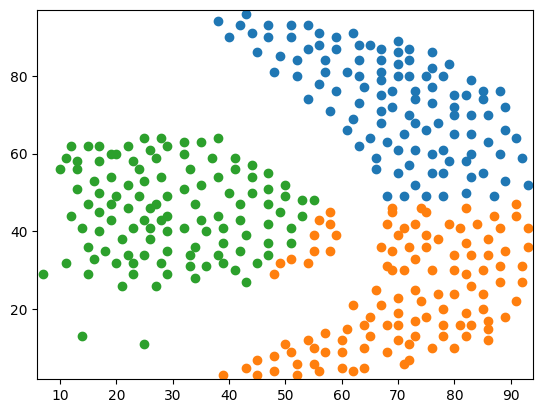

In [3]:
optimal_centroids = [] # Almacena los centroides de la configuración óptima relativa hallada
labels = [] # Almacena el índice de el clúster al que está asignado cada punto
optimal_centroids, labels, optimal_clusters = executeAndShowKmeans(10)
for i in range(0, 8):
    old_x = x.copy()
    old_y = y.copy()
    x.clear()
    y.clear()
    movePoints(old_x, old_y, 20, 0.1) # Mueve los puntos con un valor de 20% de probabilidad de èxito para cada punto

    # Variated guarda el valor booleano acerca de si variaron el número de puntos suficientes
    # Reasigned_points guarda los puntos que variaron para modificarlos en el clúster correspondiente
    # Considero que el dataset ha variado sí hay un 10% de puntos que han cambiado su cluster
    reasigned_points, variated = hasSignificantVariation((old_x, old_y, point_class), (x, y, point_class), optimal_centroids, labels)
    if(variated):
        optimal_centroids, labels, optimal_clusters = executeAndShowKmeans(10)
    else: # Si no ha variado lo suficiente, reasignamos los puntos a los clusteres correspodientes y los representamos
        #reasign_and_show(reasigned_points, optimal_clusters, [old_x, old_y])

        x.clear()
        y.clear()
        x = old_x.copy()
        y = old_y.copy()